# 1. 프로젝트 : 네이버 영화리뷰 감성분석


## 1-1. 들어가며

- 한국어 텍스트의 감정 분석 프로젝트 진행
- 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus

### 프로젝트 목표

- 3가지 이상의 모델 활용하여 Text Classification Task 구현
- `gensim` library의 유사단어 찾기를 활용하여 자체학습된 혹은 사전학습된 임베팅 레이어를 분석
- 한국어 Word2Vec을 활용하여 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성



### 1) 데이터 준비와 확인

- 필요한 라이브러리 import

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os
import re
import pandas as pd

import urllib.request
from konlpy.tag import Okt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

from keras.layers import Bidirectional, LSTM, GRU, Dense, Conv1D
from keras.layers import Embedding, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Dropout


In [2]:
# !pip install --upgrade gensim==3.8.3
from gensim.models import KeyedVectors
import gensim
gensim.__version__

'3.8.3'

In [3]:
# 훈련, 테스트 데이터 load 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [4]:
# 훈련 데이터 보기
train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [5]:
# 테스트 데이터 보기
test_data.head(10)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
5,7898805,"음악이 주가 된, 최고의 음악영화",1
6,6315043,진정한 쓰레기,0
7,6097171,"마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다",0
8,8932678,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...,0
9,6242223,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",1


### 2) 데이터로더 구성

- `imdb.data_loader()`와 동일하게 동작하는 `data_loader`를 만들어 보는 것으로 시작한다.
- `data_loader'에서는 아래와 같은 수행을 한다. 

    - 데이터의 중복 제거
    - NaN 결측치 제거
    - 한국어 토크나이저로 토큰화
    - 불용어(Stopwords) 제거
    - 사전 **word_to_index** 구성
    - 텍스트 스트링을 사전 인덱스 스트링으로 변환
    - **X_train, y_train, X_test, y_test, word_to_index** 리턴


In [6]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

- 훈련, 테스트 데이터 길이 확인  
- word_to_index 데이터 길이 및 자료형 확인

In [7]:
print(len(X_train))
print(len(X_test), '\n')
print(len(y_train))
print(len(y_test), '\n')
print(f'word_to_index : {len(word_to_index)}, {type(word_to_index)}')

146182
49157 

146182
49157 

word_to_index : 9997, <class 'dict'>


- word_to_index 데이터 내용 확인
- 위 딕셔너리를 index_to_word 로 변경 및 확인

In [8]:
print(word_to_index)

{'': 3, '.': 4, '영화': 5, '다': 6, '고': 7, '하': 8, '을': 9, '보': 10, '..': 11, '게': 12, ',': 13, '!': 14, '지': 15, '있': 16, '없': 17, '?': 18, '좋': 19, '나': 20, '었': 21, '만': 22, '는데': 23, '너무': 24, '봤': 25, '적': 26, '안': 27, '정말': 28, '로': 29, '음': 30, '것': 31, '아': 32, '네요': 33, '재밌': 34, '어': 35, '같': 36, '점': 37, '지만': 38, '진짜': 39, '했': 40, '에서': 41, '기': 42, '네': 43, '않': 44, '거': 45, '았': 46, '수': 47, '되': 48, '면': 49, 'ㅋㅋ': 50, '말': 51, '연기': 52, '인': 53, '주': 54, '내': 55, '최고': 56, '~': 57, '평점': 58, '이런': 59, '던': 60, '어요': 61, '할': 62, '왜': 63, '겠': 64, '1': 65, '스토리': 66, '해': 67, '습니다': 68, 'ㅋㅋㅋ': 69, '...': 70, '드라마': 71, '생각': 72, '아니': 73, '더': 74, '그': 75, '싶': 76, '사람': 77, '듯': 78, '때': 79, '감동': 80, '함': 81, '배우': 82, '본': 83, '까지': 84, '뭐': 85, '알': 86, '만들': 87, '내용': 88, '볼': 89, '감독': 90, '보다': 91, '라': 92, '그냥': 93, '재미': 94, '시간': 95, '지루': 96, '중': 97, '재미있': 98, '년': 99, '10': 100, '였': 101, '잼': 102, '사랑': 103, '못': 104, '냐': 105, '재미없': 106, '쓰레기': 107, '서': 1

- 위 데이터에서 보면 0 ~ 2 index가 비어있는게 확인된다.
- 관례적으로 index 순서대로 `<PAD>, <BOS>, <UNK>` 를 넣어주자.

In [9]:
word_to_index['<PAD>'] = 0  # 패딩
word_to_index['<BOS>'] = 1  # 모든 문장의 시작
word_to_index['<UNK>'] = 2  # Unknown을 의미

- 위 데이터를 index_to_word 형태로 딕셔너리 생성

In [10]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [11]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공
___

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [12]:
# 텍스트 데이터 문장 길이의 리스트 생성
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차
print('문장길이 평균 :', round(np.mean(num_tokens), 1))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 :',round(np.std(num_tokens), 1))

# 예를들어, 최대 길이를 (평균 + 2.0*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2.0 * np.std(num_tokens)
max_len = int(max_tokens)
print('pad_sequences max_len :', max_len)
print('전체 문장의 {:.3f}% 가 maxlen 설정값 이내에 포함된다! '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 : 16.0
문장길이 최대 : 116
문장길이 표준편차 : 12.8
pad_sequences max_len : 41
전체 문장의 0.934% 가 maxlen 설정값 이내에 포함된다! 


- 전체 문장이 maxlen 설정값 이내에 포함되는 값이 클 수록 좋을 것이라고 판단
- 이상치(길이가 과한 문장들)를 가진 데이터를 제거하고 학습하는 것이 더 효율적이라고 판단
- maxlen을 int(평균 + 2.0*표준편차)로 지정

In [13]:
# padding을 통해 문장의 길이를 맞춘다.
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='post',
                                                        maxlen=max_len)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=max_len)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [14]:
X_train[0]

array([ 32,  74, 919,   4,   4,  39, 228,  20,  33, 748,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

### 4) 모델 및 validation set 구성


In [15]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 41  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

### 4-1) GlobalMaxPooling1D

In [16]:
# GlobalMaxPooling1D 모델 구성
model_gmp1d = keras.Sequential()
model_gmp1d.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp1d.add(keras.layers.GlobalMaxPooling1D())
model_gmp1d.add(keras.layers.Dense(8, activation='relu'))
model_gmp1d.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp1d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 41)          410000    
_________________________________________________________________
global_max_pooling1d (Global (None, 41)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 410,345
Trainable params: 410,345
Non-trainable params: 0
_________________________________________________________________


### 4-2) LSTM

In [17]:
# LSTM 레이어 모델 구성
model_lstm = keras.Sequential(name='LSTM')
model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(keras.layers.LSTM(16))
model_lstm.add(keras.layers.Dense(8, activation='relu'))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3712      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 413,857
Trainable params: 413,857
Non-trainable params: 0
_________________________________________________________________


### 4-3) Convolution Neural Network(1-D CNN)

In [18]:
# 1-D CNN 모델 구성
model_cnn = keras.Sequential(name='CNN')
model_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(keras.layers.Conv1D(32, 3, activation='relu'))
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(8, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          3968      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1552      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9       

### 4-4) validation set 구성

In [19]:
from sklearn.model_selection import train_test_split

X_train_sp, X_val, y_train_sp, y_val = train_test_split(X_train, y_train,
                                                          test_size=0.3,
                                                          random_state=15)

### 5) 모델 훈련 개시

In [20]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [21]:
# GlobalMaxPooling1D 모델 학습

model_gmp1d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            
epochs=10

history_gmp1d = model_gmp1d.fit(X_train_sp,
                                y_train_sp,
                                epochs=epochs,
                                batch_size=128,
                                validation_data=(X_val, y_val),
                                callbacks=[early_stopping],
                                verbose=1)

Epoch 1/10
800/800 [==============================] - 4s 4ms/step - loss: 0.4583 - accuracy: 0.7886 - val_loss: 0.3586 - val_accuracy: 0.8418
Epoch 2/10
800/800 [==============================] - 3s 4ms/step - loss: 0.3179 - accuracy: 0.8661 - val_loss: 0.3455 - val_accuracy: 0.8503
Epoch 3/10
800/800 [==============================] - 3s 3ms/step - loss: 0.2730 - accuracy: 0.8885 - val_loss: 0.3508 - val_accuracy: 0.8509
Epoch 4/10
800/800 [==============================] - 3s 4ms/step - loss: 0.2371 - accuracy: 0.9061 - val_loss: 0.3680 - val_accuracy: 0.8483
Epoch 5/10
800/800 [==============================] - 3s 3ms/step - loss: 0.2052 - accuracy: 0.9208 - val_loss: 0.3903 - val_accuracy: 0.8453
Epoch 00005: early stopping


In [22]:
# LSTM 모델 학습

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            
epochs=10

history_lstm = model_lstm.fit(X_train_sp,
                              y_train_sp,
                              epochs=epochs,
                              batch_size=128,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stopping],
                              verbose=1)

Epoch 1/10
800/800 [==============================] - 7s 6ms/step - loss: 0.4298 - accuracy: 0.7920 - val_loss: 0.3591 - val_accuracy: 0.8413
Epoch 2/10
800/800 [==============================] - 5s 6ms/step - loss: 0.3279 - accuracy: 0.8593 - val_loss: 0.3505 - val_accuracy: 0.8454
Epoch 3/10
800/800 [==============================] - 5s 6ms/step - loss: 0.3037 - accuracy: 0.8704 - val_loss: 0.3475 - val_accuracy: 0.8465
Epoch 4/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2805 - accuracy: 0.8801 - val_loss: 0.3649 - val_accuracy: 0.8467
Epoch 5/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2587 - accuracy: 0.8885 - val_loss: 0.3593 - val_accuracy: 0.8492
Epoch 6/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2401 - accuracy: 0.8963 - val_loss: 0.3775 - val_accuracy: 0.8500
Epoch 00006: early stopping


In [23]:
# CNN 모델 학습

model_cnn.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history_cnn = model_cnn.fit(X_train_sp,
                            y_train_sp,
                            epochs=epochs,
                            batch_size=128,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping],
                            verbose=1)

Epoch 1/10
800/800 [==============================] - 6s 5ms/step - loss: 0.4088 - accuracy: 0.8096 - val_loss: 0.3403 - val_accuracy: 0.8509
Epoch 2/10
800/800 [==============================] - 4s 5ms/step - loss: 0.2936 - accuracy: 0.8780 - val_loss: 0.3359 - val_accuracy: 0.8556
Epoch 3/10
800/800 [==============================] - 4s 5ms/step - loss: 0.2338 - accuracy: 0.9077 - val_loss: 0.3530 - val_accuracy: 0.8531
Epoch 4/10
800/800 [==============================] - 4s 5ms/step - loss: 0.1721 - accuracy: 0.9358 - val_loss: 0.3985 - val_accuracy: 0.8470
Epoch 5/10
800/800 [==============================] - 4s 5ms/step - loss: 0.1180 - accuracy: 0.9593 - val_loss: 0.4859 - val_accuracy: 0.8424
Epoch 00005: early stopping


In [24]:
# 3개 모델 평가

results_gmp1d = model_gmp1d.evaluate(X_test, y_test, verbose=2)
results_lstm = model_lstm.evaluate(X_test, y_test, verbose=2)
results_cnn = model_cnn.evaluate(X_test, y_test, verbose=2)

# print(results_gmp1d)
# print(results_lstm)
# print(results_cnn)

1537/1537 - 2s - loss: 0.3997 - accuracy: 0.8401
1537/1537 - 3s - loss: 0.3834 - accuracy: 0.8478
1537/1537 - 2s - loss: 0.5049 - accuracy: 0.8355


### 6) Loss, Accuracy 그래프 시각화

### 6-1) GlobalMaxPooling1D

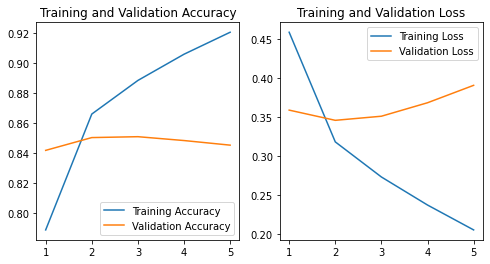

In [25]:
history_gmp1d_dict = history_gmp1d.history
acc = history_gmp1d_dict['accuracy']
val_acc = history_gmp1d_dict['val_accuracy']
loss = history_gmp1d_dict['loss']
val_loss = history_gmp1d_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 6-2) LSTM

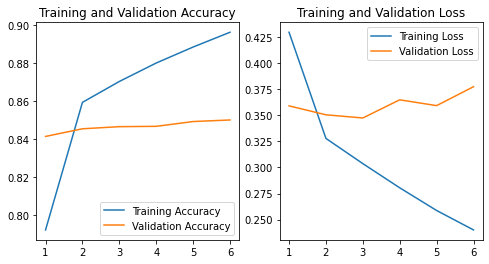

In [26]:
history_lstm_dict = history_lstm.history
acc = history_lstm_dict['accuracy']
val_acc = history_lstm_dict['val_accuracy']
loss = history_lstm_dict['loss']
val_loss = history_lstm_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 6-3) Convolution Neural Network(1-D CNN)

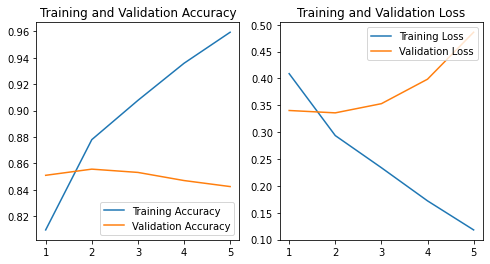

In [27]:
history_cnn_dict = history_cnn.history
acc = history_cnn_dict['accuracy']
val_acc = history_cnn_dict['val_accuracy']
loss = history_cnn_dict['loss']
val_loss = history_cnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 7) 학습된 Embedding 레이어 분석

In [28]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 임베딩 레이어 차원 확인
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # 출력 형태 : (vocab_size, embedding_dim)

(10000, 41)


In [29]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_proj.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 기록

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [30]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("행복")

[('여신', 0.9687254428863525),
 ('미어지', 0.9679340124130249),
 ('총기', 0.9676291346549988),
 ('굳', 0.9641667008399963),
 ('성찰', 0.9630301594734192),
 ('흥미진진', 0.9612916111946106),
 ('찡', 0.9612166285514832),
 ('굿', 0.9595437049865723),
 ('슬펐', 0.957953691482544),
 ('감명깊', 0.9574987292289734)]

In [31]:
word_vectors.similar_by_word("믿음")

[('데스노트', 0.5753224492073059),
 ('황', 0.5753167867660522),
 ('덕분', 0.5564686059951782),
 ('잖아', 0.5480332374572754),
 ('부르', 0.5473937392234802),
 ('드', 0.5246117115020752),
 ('따라', 0.5186043977737427),
 ('혹시', 0.515694797039032),
 ('인터', 0.5074679851531982),
 ('묘한', 0.5068386793136597)]

- 위와 같이 영어로 된 Word2Vec 으로는 "행복", "믿음"을 키워드로 한 비슷한 의미의 단어를 찾기 어렵다는 것을 알 수 있다.
- 더 좋은 모델의 성능을 위해서는 한국어 버전의 Word2Vec 활용하여 성능개선을 해보자.


### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

- 한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.

- [Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)

위 링크에서 적절한 `ko.bin`을 찾아 이용하세요. 그리고 `gensim` 버전을 `3.x.x`로 낮춰야 오류가 나지 않습니다.



In [32]:
# !pip install --upgrade gensim==3.8.3
from gensim.models import KeyedVectors
import gensim
gensim.__version__

'3.8.3'

In [33]:
# 한국어 Word2Vec 파일 불러와 ko_word2vec에 저장하기

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
ko_word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = ko_word2vec['행복']
vector.shape     # 200dim의 워드 벡터

/tmp/ipykernel_4786/3348225738.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = ko_word2vec['행복']


(200,)

In [34]:
ko_word2vec.similar_by_word("행복")

/tmp/ipykernel_4786/1406014682.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  ko_word2vec.similar_by_word("행복")


[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.6299898028373718),
 ('젊음', 0.6187379360198975),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

In [35]:
ko_word2vec.similar_by_word("믿음")

/tmp/ipykernel_4786/3278625075.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  ko_word2vec.similar_by_word("믿음")


[('신념', 0.7933070063591003),
 ('가르침', 0.7017691135406494),
 ('관념', 0.6922615170478821),
 ('신앙', 0.6911468505859375),
 ('편견', 0.6784049868583679),
 ('본성', 0.6666018962860107),
 ('사고방식', 0.6615393161773682),
 ('욕망', 0.6482665538787842),
 ('교의', 0.645539402961731),
 ('하나님', 0.6454751491546631)]

- Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 의미적 유사도가 가까운 것이 제대로 학습된 것을 확인할 수 있다.  


### 8-1) 한국어 버전의 Word2Vec을 사용해서 이전의 세 가지 모델을 재 학습시키고 평가해보자.

- 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체
- 사전학습된 임베딩 레이어의 차원 수 그대로 따라간다.

In [36]:
vocab_size = 10000     # 단어 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수

# 사전학습된 임베딩 레이어의 차원 수 그대로 따라가는 것이 좋아요!
embedding_matrix = np.random.rand(vocab_size, word_vector_dim) 

#embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 순서대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in ko_word2vec:
        embedding_matrix[i] = ko_word2vec[index_to_word[i]]

/tmp/ipykernel_4786/316040085.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in ko_word2vec:
/tmp/ipykernel_4786/316040085.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = ko_word2vec[index_to_word[i]]


### 8-1-1) GlobalMaxPooling1D

In [37]:
# GlobalMaxPooling1D 모델 구성
model_gmp1d_ko = keras.Sequential()
model_gmp1d_ko.add(keras.layers.Embedding(vocab_size,
                                          word_vector_dim,
                                          embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                          input_length=max_len, 
                                          trainable=True))   # trainable을 True로 주면 Fine-tuning
model_gmp1d_ko.add(keras.layers.GlobalMaxPooling1D())
model_gmp1d_ko.add(keras.layers.Dense(8, activation='relu'))
model_gmp1d_ko.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp1d_ko.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_gmp1d_ko.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs_gmp=30
history_gmp1d_ko = model_gmp1d_ko.fit(X_train_sp,
                                      y_train_sp,
                                      epochs=epochs_gmp,
                                      batch_size=128,
                                      validation_data=(X_val, y_val),
                                      callbacks=[early_stopping],
                                      verbose=1)

Epoch 1/30
800/800 [==============================] - 4s 4ms/step - loss: 0.6176 - accuracy: 0.6471 - val_loss: 0.5329 - val_accuracy: 0.7314
Epoch 2/30
800/800 [==============================] - 3s 4ms/step - loss: 0.4921 - accuracy: 0.7621 - val_loss: 0.4670 - val_accuracy: 0.7782
Epoch 3/30
800/800 [==============================] - 3s 4ms/step - loss: 0.4335 - accuracy: 0.8000 - val_loss: 0.4372 - val_accuracy: 0.7966
Epoch 4/30
800/800 [==============================] - 3s 4ms/step - loss: 0.3938 - accuracy: 0.8248 - val_loss: 0.4203 - val_accuracy: 0.8061
Epoch 5/30
800/800 [==============================] - 3s 4ms/step - loss: 0.3656 - accuracy: 0.8398 - val_loss: 0.4352 - val_accuracy: 0.8025
Epoch 6/30
800/800 [==============================] - 3s 4ms/step - loss: 0.3431 - accuracy: 0.8508 - val_loss: 0.4084 - val_accuracy: 0.8148
Epoch 7/30
800/800 [==============================] - 3s 4ms/step - loss: 0.3207 - accuracy: 0.8639 - val_loss: 0.4051 - val_accuracy: 0.8199
Epoch 

### 8-1-2) LSTM

In [39]:
# LSTM 레이어 모델 구성
model_lstm_ko = keras.Sequential(name='LSTM')
model_lstm_ko.add(keras.layers.Embedding(vocab_size, 
                                         word_vector_dim,
                                         embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                         input_length=max_len, 
                                         trainable=True))   # trainable을 True로 주면 Fine-tuning
model_lstm_ko.add(keras.layers.LSTM(128))
model_lstm_ko.add(keras.layers.Dense(8, activation='relu'))
model_lstm_ko.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm_ko.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [40]:
model_lstm_ko.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs_lstm=20
history_lstm_ko = model_lstm_ko.fit(X_train_sp,
                                    y_train_sp,
                                    epochs=epochs_lstm,
                                    batch_size=128,
                                    validation_data=(X_val, y_val),
                                    callbacks=[early_stopping],
                                    verbose=1)

Epoch 1/20
800/800 [==============================] - 8s 8ms/step - loss: 0.4960 - accuracy: 0.7263 - val_loss: 0.3516 - val_accuracy: 0.8451
Epoch 2/20
800/800 [==============================] - 6s 7ms/step - loss: 0.3173 - accuracy: 0.8652 - val_loss: 0.3235 - val_accuracy: 0.8613
Epoch 3/20
800/800 [==============================] - 6s 7ms/step - loss: 0.2677 - accuracy: 0.8887 - val_loss: 0.3178 - val_accuracy: 0.8656
Epoch 4/20
800/800 [==============================] - 6s 7ms/step - loss: 0.2287 - accuracy: 0.9067 - val_loss: 0.3323 - val_accuracy: 0.8646
Epoch 5/20
800/800 [==============================] - 6s 7ms/step - loss: 0.1931 - accuracy: 0.9238 - val_loss: 0.3475 - val_accuracy: 0.8625
Epoch 6/20
800/800 [==============================] - 6s 7ms/step - loss: 0.1596 - accuracy: 0.9384 - val_loss: 0.3835 - val_accuracy: 0.8616
Epoch 00006: early stopping


### 8-1-3) Convolution Neural Network(1-D CNN)

In [41]:
# 1-D CNN 모델 구성
model_cnn_ko = keras.Sequential(name='CNN')
model_cnn_ko.add(keras.layers.Embedding(vocab_size,
                                        word_vector_dim,
                                        embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                        input_length=max_len, 
                                        trainable=True))   # trainable을 True로 주면 Fine-tuning
model_cnn_ko.add(keras.layers.Conv1D(32, 3, activation='relu'))
model_cnn_ko.add(keras.layers.MaxPooling1D(5))
model_cnn_ko.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_cnn_ko.add(keras.layers.GlobalMaxPooling1D())
model_cnn_ko.add(keras.layers.Dense(8, activation='relu'))
model_cnn_ko.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn_ko.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 39, 32)            19232     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 16)             1552      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9       

In [42]:
model_cnn_ko.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs_cnn=20
history_cnn_ko = model_cnn_ko.fit(X_train_sp,
                                  y_train_sp,
                                  epochs=epochs_cnn,
                                  batch_size=128,
                                  validation_data=(X_val, y_val),
                                  callbacks=[early_stopping],
                                  verbose=1)

Epoch 1/20
800/800 [==============================] - 5s 6ms/step - loss: 0.5014 - accuracy: 0.7465 - val_loss: 0.3997 - val_accuracy: 0.8197
Epoch 2/20
800/800 [==============================] - 4s 5ms/step - loss: 0.3524 - accuracy: 0.8464 - val_loss: 0.3617 - val_accuracy: 0.8404
Epoch 3/20
800/800 [==============================] - 4s 5ms/step - loss: 0.3024 - accuracy: 0.8733 - val_loss: 0.3482 - val_accuracy: 0.8500
Epoch 4/20
800/800 [==============================] - 4s 5ms/step - loss: 0.2697 - accuracy: 0.8898 - val_loss: 0.3649 - val_accuracy: 0.8466
Epoch 5/20
800/800 [==============================] - 4s 5ms/step - loss: 0.2405 - accuracy: 0.9034 - val_loss: 0.3700 - val_accuracy: 0.8467
Epoch 6/20
800/800 [==============================] - 4s 5ms/step - loss: 0.2152 - accuracy: 0.9157 - val_loss: 0.3881 - val_accuracy: 0.8428
Epoch 00006: early stopping


In [43]:
# 한국어 버전 3개 모델 평가

results_gmp1d_ko = model_gmp1d_ko.evaluate(X_test, y_test, verbose=2)
results_lstm_ko = model_lstm_ko.evaluate(X_test, y_test, verbose=2)
results_cnn_ko = model_cnn_ko.evaluate(X_test, y_test, verbose=2)

1537/1537 - 2s - loss: 0.4201 - accuracy: 0.8225
1537/1537 - 3s - loss: 0.3984 - accuracy: 0.8558
1537/1537 - 3s - loss: 0.3950 - accuracy: 0.8420


### 8-1-4) LSTM

- dropout 추가

In [44]:
# LSTM 레이어 모델 구성
model_lstm_ko_do = keras.Sequential(name='LSTM')
model_lstm_ko_do.add(keras.layers.Embedding(vocab_size, 
                                           word_vector_dim,
                                           embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                           input_length=max_len, 
                                           trainable=True))   # trainable을 True로 주면 Fine-tuning
model_lstm_ko_do.add(keras.layers.LSTM(128))
model_lstm_ko_do.add(keras.layers.Dropout(0.3)) 
model_lstm_ko_do.add(keras.layers.Dense(8, activation='relu'))
model_lstm_ko_do.add(keras.layers.Dropout(0.3)) 
model_lstm_ko_do.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm_ko_do.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
____________________________________________________

In [45]:
model_lstm_ko_do.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs_lstm=20
history_lstm_ko_do = model_lstm_ko_do.fit(X_train_sp,
                                         y_train_sp,
                                         epochs=epochs_lstm,
                                         batch_size=128,
                                         validation_data=(X_val, y_val),
                                         callbacks=[early_stopping],
                                         verbose=1)

Epoch 1/20
800/800 [==============================] - 8s 8ms/step - loss: 0.6029 - accuracy: 0.6248 - val_loss: 0.4055 - val_accuracy: 0.8155
Epoch 2/20
800/800 [==============================] - 6s 7ms/step - loss: 0.3636 - accuracy: 0.8491 - val_loss: 0.3317 - val_accuracy: 0.8553
Epoch 3/20
800/800 [==============================] - 6s 7ms/step - loss: 0.3099 - accuracy: 0.8763 - val_loss: 0.3341 - val_accuracy: 0.8514
Epoch 4/20
800/800 [==============================] - 6s 7ms/step - loss: 0.2745 - accuracy: 0.8931 - val_loss: 0.3310 - val_accuracy: 0.8617
Epoch 5/20
800/800 [==============================] - 6s 7ms/step - loss: 0.2433 - accuracy: 0.9068 - val_loss: 0.3519 - val_accuracy: 0.8624
Epoch 6/20
800/800 [==============================] - 6s 7ms/step - loss: 0.2108 - accuracy: 0.9207 - val_loss: 0.3777 - val_accuracy: 0.8627
Epoch 7/20
800/800 [==============================] - 6s 7ms/step - loss: 0.1833 - accuracy: 0.9317 - val_loss: 0.4304 - val_accuracy: 0.8597
Epoch 

In [46]:
results_lstm_ko_do = model_lstm_ko_do.evaluate(X_test, y_test, verbose=2)

1537/1537 - 3s - loss: 0.4353 - accuracy: 0.8569


## 회고

1. 학습을 진행할 수록 validation accuracy 는 정체되고, validation loss는 오히려 증가하였다.
   위 그래프에서 확인된다.
   
   
2. 과적합으로 판단되어 조기 훈련 종료를 위해 **early_stopping**을 적용하여 **val_loss**가 최적의 값이 나오도록  patience를 다양하게 시도해 본 후 `patience=3`을 적용했다.(투자 시간의 save에도 많은 기여를 하였다.)


3. 최적의 하이퍼 파라미터를 찾기 위해 다양하게 적용하다 보니 시간의 투자가 상당히 필요했고 시도한 내용은 아래와 같다.
    - word_vector_dim : 41, 35, 28 각각의 경우
    - batch size : 64, 128, 256, 512 각각의 경우 
    - padding : pre, post 각각의 경우  
    
    
4. 위와 같은 다양한 시도 후 각각의 결과를 테이블로 정리해 보았다.
    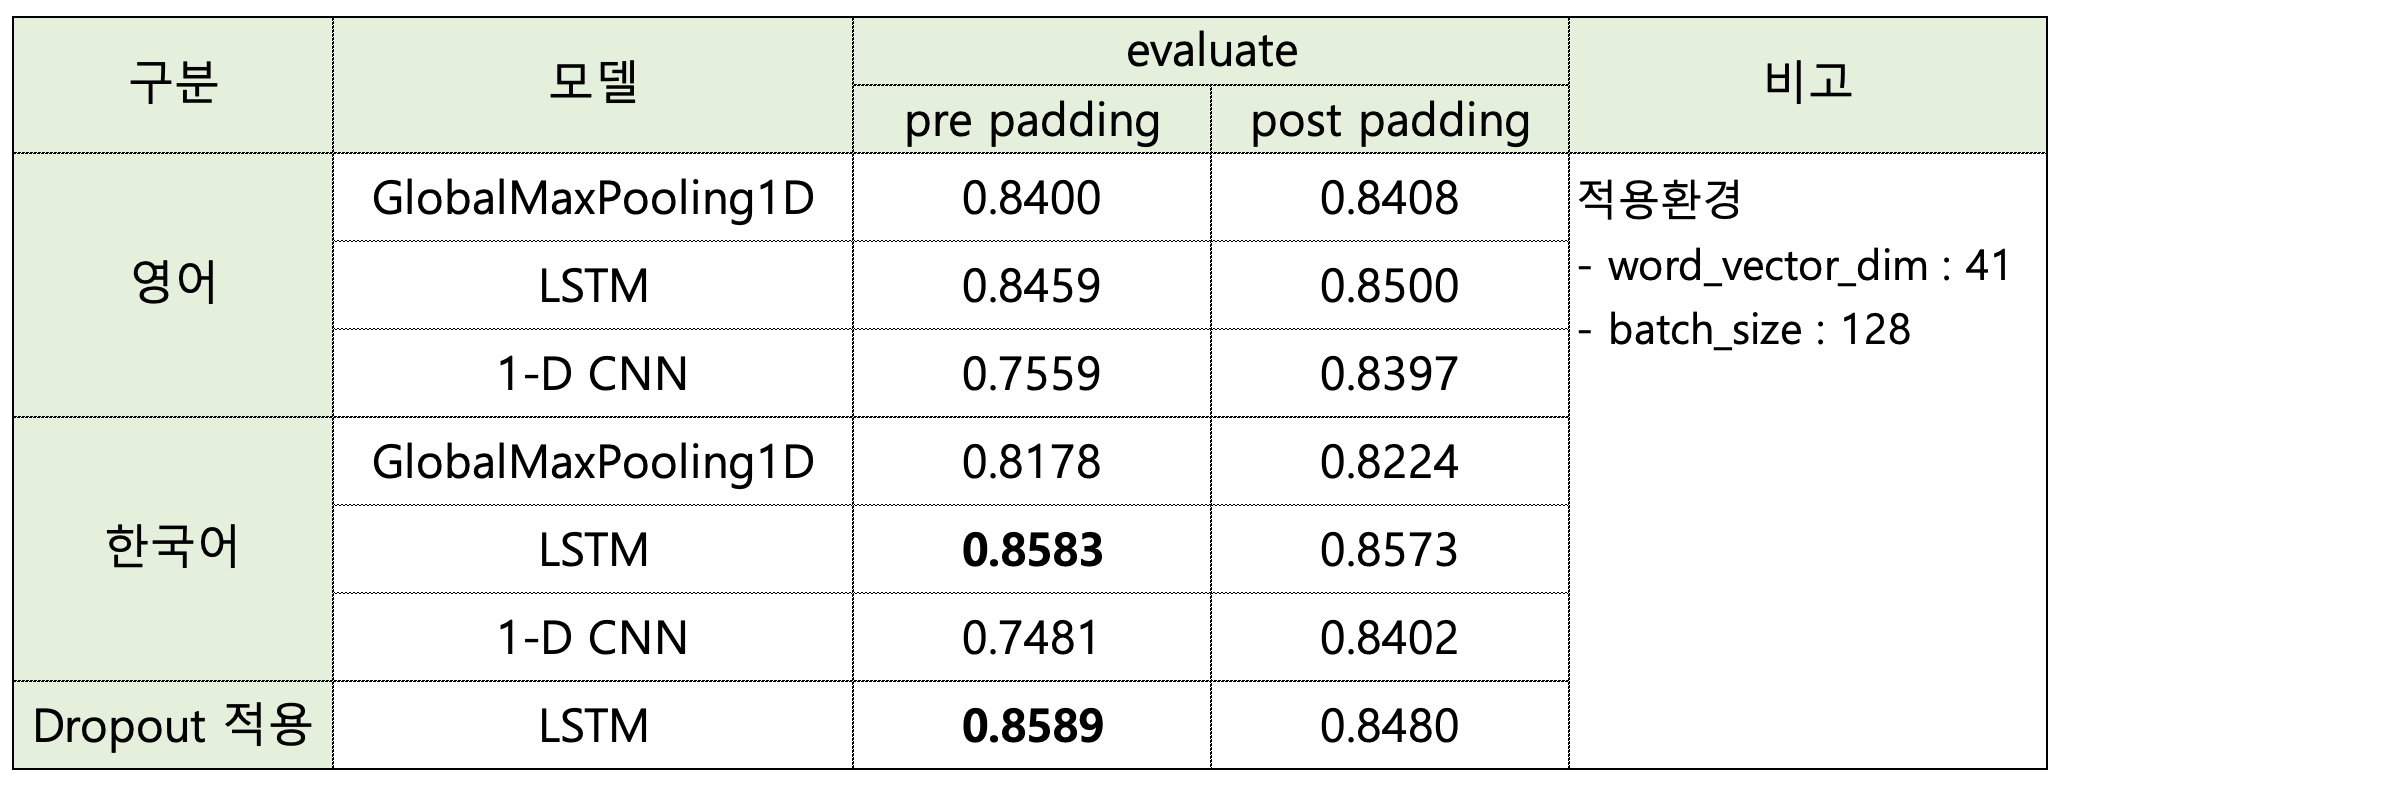
    
    
5. 위의 결과로 보면
    - 다양한 시도 중에 가장 좋은 결과로 판단된 테이블이다. 
    - 영어 Word2Vec 보다 한국어 Word2Vec을 활용했을 때가 더 좋은 결과를 보여주었다.
    - 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상으로 충족되었다.
    - 예상했던데로 RNN 계역의 LSTM 모델이 가장 좋은 결과를 보여주었다.
    - 하지만 padding 에서 일반적으로 pre-padding이 post-padding보다 더 우수하다고 하였는데 실제 결과는 post-padding 에서 더 좋았다. 이 부분은 여러가지 방향으로 알아보았으나 왜 이런 결과가 나왔는지는 확인하지 못했다.
    - 각각의 하이퍼 파라미터 차이로 인한 평가(evaluate) 결과는 생각보다 드라마틱한 차이를 보이지는 않았다.
    - 결국 데이터 정제 품질에 따라 가장 많은 영향을 받는 것으로 판단된다.
   

- 위 과정은 아래 링크들을 참고하여 진행하였습니다.

[참고 링크 1](https://github.com/Kwon-Seung-Min/AIFFEL-Exp-KSM/blob/master/Exp07_final_ksm.ipynb)
[참고 링크 2](https://github.com/ai-rtistic/AIFFEL-Project/blob/master/Exploration/EP07_Naver_Movie_Sentiment_Classification.ipynb)